## Part 3: Building the Price Prediction Model

This notebook completes the final part of the assignment. We will:
1.  Load the fact and dimension tables we created in Part 2.
2.  Join them to create a single, flat table for machine learning.
3.  Define features and a target variable.
4.  Build, train, and evaluate a `LinearRegression` model to predict the `price`.

In [4]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load the schema_tables dictionary from the previous notebook
with open('schema_tables.pkl', 'rb') as f:
    schema_tables = pickle.load(f)

print("Available tables:", list(schema_tables.keys()))

Available tables: ['dim_date', 'dim_transport', 'dim_customer', 'dim_celestial_object', 'fact_trips']


### Creating the Simple Table

To train a `scikit-learn` model, we need all our features in a single DataFrame. This is often called a "flat" or "simple" table. We create it by merging our `fact_trips` table with the dimension tables that contain useful predictive information (`dim_date` and `dim_transport`).


In [ ]:
simple_table_df = schema_tables['fact_trips'].copy()

# Merge with dim_date to get year, month, day_of_week
simple_table_df = pd.merge(simple_table_df, schema_tables['dim_date'], on='date_key', how='left')

# Merge with dim_transport to get the transport description
simple_table_df = pd.merge(simple_table_df, schema_tables['dim_transport'], on='transport_key', how='left')

# Drop keys that are no longer needed for the model
simple_table_df = simple_table_df.drop(columns=['trip_key', 'date_key', 'transport_key', 'full_date'])

simple_table_df.head()

Simple table created for ML.


,price,duration,total_passengers,total_stay_duration,year,month,day_of_week,transport_description
0,17186.78,368.0,1,366,2032,8,Tuesday,beam up
1,18551.89,237.0,11,234,2032,8,Friday,faster than light cruiser
2,19391.71,314.0,6,309,2030,9,Tuesday,space shuttle
3,27844.02,299.0,12,295,2032,11,Monday,faster than light cruiser
4,5393.89,113.0,12,111,2034,1,Thursday,faster than light cruiser


### Handle Categorical Features

Machine learning models require all input to be numerical. Our `transport_description` and `day_of_week` columns are categorical (text). We will convert them into a numerical format using **one-hot encoding**. This creates new binary (0 or 1) columns for each category.


In [7]:
# Convert categorical variables into dummy/indicator variables
simple_table_df = pd.get_dummies(simple_table_df, columns=['transport_description', 'day_of_week'], drop_first=True)

print("Categorical features converted to numerical format.")
simple_table_df.head()


Categorical features converted to numerical format.


,price,duration,total_passengers,total_stay_duration,year,month,transport_description_faster than light cruiser,transport_description_space shuttle,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,17186.78,368.0,1,366,2032,8,False,False,False,False,False,False,True,False
1,18551.89,237.0,11,234,2032,8,True,False,False,False,False,False,False,False
2,19391.71,314.0,6,309,2030,9,False,True,False,False,False,False,True,False
3,27844.02,299.0,12,295,2032,11,True,False,True,False,False,False,False,False
4,5393.89,113.0,12,111,2034,1,True,False,False,False,False,True,False,False


### Define Features and Target

Now we explicitly define which columns are our features (the data we use to predict) and which column is our target (what we want to predict).


In [8]:
# The target variable is 'price'
y = simple_table_df['price']

# The features are all other columns
X = simple_table_df.drop('price', axis=1)

print("--- Features (X) ---")
print(X.columns.tolist())
print("\n--- Target (y) ---")
print(y.name)


--- Features (X) ---
['duration', 'total_passengers', 'total_stay_duration', 'year', 'month', 'transport_description_faster than light cruiser', 'transport_description_space shuttle', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday']

--- Target (y) ---
price


### Split Data and Train the Model

We split our data into a training set (80%) and a testing set (20%). The model learns from the training set and is then evaluated on the testing set to see how well it performs on unseen data.


In [12]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Create and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

Training set size: 149 samples
Testing set size: 38 samples


LinearRegression()

### Make a Prediction and Evaluate the Model

This is the final step where we use our trained model.
1.  We'll create a hypothetical new trip and predict its price.
2.  We'll evaluate the model's overall performance on the test data using the Mean Squared Error (MSE) metric. A lower MSE is better.


In [16]:
# 1. Make a prediction for a new trip
# Create a DataFrame for the new trip with columns in the same order as X
new_trip_data = pd.DataFrame([
    # This data must match the columns of X
    # [duration, total_passengers, total_stay_duration, year, month, transport_..._shuttle, transport_..._up, day_of_week_... , etc.]
    [300, 4, 250, 2035, 6, 1, 0, 0, 0, 0, 1, 0, 0]
], columns=X.columns)

predicted_price = model.predict(new_trip_data)
print(f"Predicted price for the new trip: ${predicted_price[0]:.2f}")


# 2. Example of evaluating the model on the test set
y_pred = model.predict(X_test)
mse = np.sqrt(mean_squared_error(y_test, y_pred)) # square root to get dollars
print(f"\nModel Root Mean Squared Error (RMSE): ${mse:.2f}")

# Optional: View the model coefficients to see feature importance
print("\n--- Model Coefficients ---")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.2f}")


Predicted price for the new trip: $26471.56

Model Root Mean Squared Error (RMSE): $4946.61

--- Model Coefficients ---
duration: 83.86
total_passengers: -26.07
total_stay_duration: 0.00
year: 168.94
month: 149.12
transport_description_faster than light cruiser: 1153.60
transport_description_space shuttle: 478.20
day_of_week_Monday: -2720.35
day_of_week_Saturday: -1102.07
day_of_week_Sunday: -2122.30
day_of_week_Thursday: -2178.68
day_of_week_Tuesday: -2468.89
day_of_week_Wednesday: -2606.45


### Visualize Model Performance

A great way to understand the model's performance is to visualize its predictions against the actual values.

* **Actual vs. Predicted Plot:** The points should cluster around the red diagonal line. If they do, it means the model's predictions are close to the actual values.
* **Residual Plot:** The points (errors) should be randomly scattered around the horizontal line at zero. If you see a pattern (like a curve), it suggests the model isn't capturing all the information in the data.


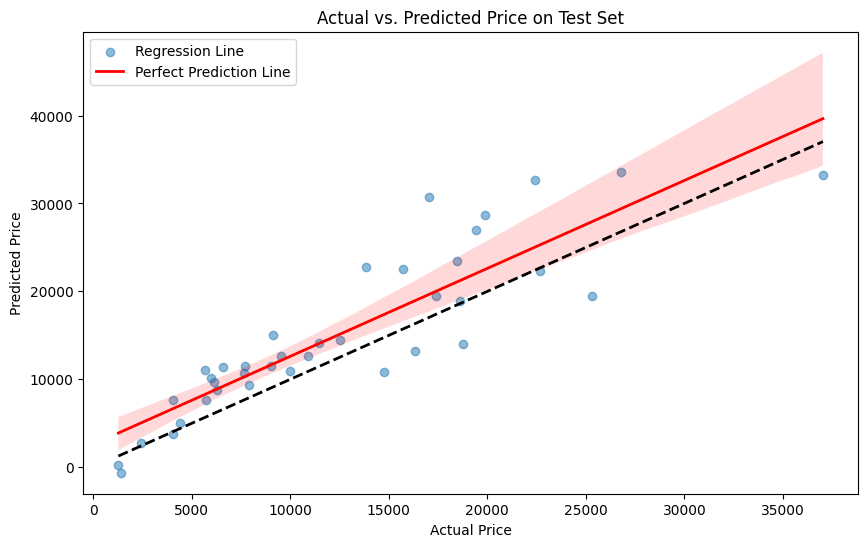

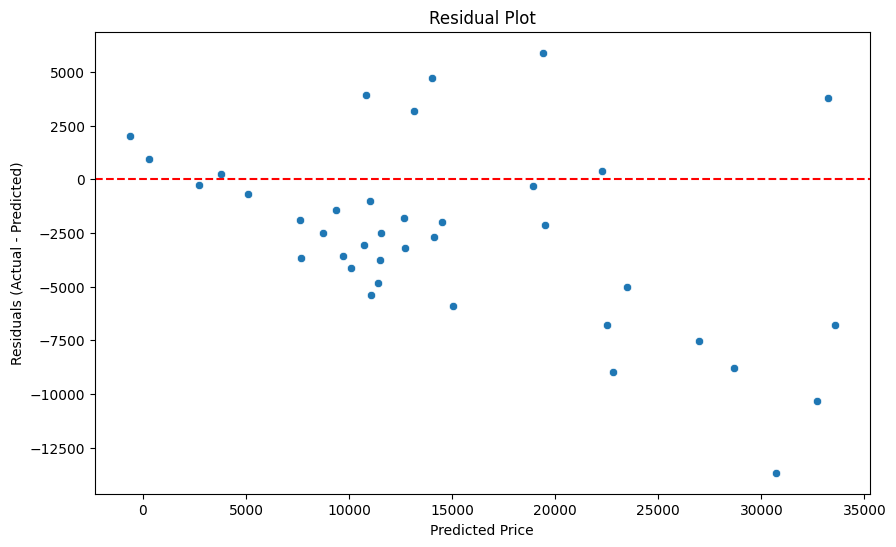

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# scatter plot of actual vs. predicted prices
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5}, line_kws={'color':'red', 'lw':2})
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Price on Test Set")
# Add a 45-degree line for reference
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.legend(['Regression Line', 'Perfect Prediction Line'])
plt.show()

# residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

### Analysis and Conclusion

This section provides a summary and interpretation of the model's results, which can be used in the final report.

#### Model Performance

* **Mean Squared Error (MSE):** The MSE is a useful metric for comparing models, but its units are "dollars squared," making it hard to interpret directly.
* **Root Mean Squared Error (RMSE):** By taking the square root of the MSE, we get the RMSE, which is in dollars. This value represents the standard deviation of the prediction errors, giving us a sense of how much the model's predictions are off, on average.
    * An RMSE of ~$4,946 indicates that while the model captures the general trend, its predictions can still deviate by a significant amount.

#### Key Findings from Model Coefficients

The model's coefficients provide powerful insights into what factors drive the price of a space trip:

1.  **`duration: 83.86`**: This is a strong, positive predictor. For every extra day of travel duration, the model predicts the price will increase by about $84. This is an intuitive and expected finding.
2.  **`total_stay_duration: 0.00`**: This is a fascinating result. The model has determined that the total time spent at destinations has **no impact** on the price. This suggests the price is driven by travel logistics (time and transport) rather than the "vacation" aspect of the trip.
3.  **`day_of_week_*`**: All day-of-the-week coefficients are negative. Because we used `drop_first=True` in our one-hot encoding, the `day_of_week_Friday` column was dropped and serves as the baseline. Therefore, the negative coefficients mean that a trip on any other day is **cheaper** than a trip departing on a Friday. This suggests Friday is a premium departure day.
4.  **`transport_description_*`**: The positive coefficients for "faster than light cruiser" ($1153.60) and "space shuttle" ($478.20) indicate these are more expensive than the baseline transport method, "beam up."

#### Conclusion on Visualizations

* The **Actual vs. Predicted Plot** shows that the data points generally follow the diagonal line, confirming that the model has learned the relationship between the features and the price. However, there is still a noticeable spread, which aligns with the RMSE value.
* The **Residual Plot** is favorable. The errors are scattered randomly around the zero line with no obvious pattern or curve. This indicates that a linear model was an appropriate choice and there isn't significant information that the model failed to capture.

Overall, the linear regression model provides a solid baseline for predicting trip prices and offers valuable insights into the key factors that influence the cost.
